# Mixture Models


The previous notebook had a very simple model, only using a single feature. This is clearly far to simple and we have to take all features into account. Here we'll expand the model to include all features, each with their own sigma and likelihood.


In [1]:
%load_ext nb_black
import seaborn as sns
import pymc3 as pm
import pandas as pd
import numpy as np
import arviz as az

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


<IPython.core.display.Javascript object>

In [2]:
penguin_df = (
    pd.read_csv("./data/penguins_size.csv").drop(columns=["island", "sex"]).dropna()
)
penguin_df

,species,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
0,Adelie,39.1,18.7,181.0,3750.0
1,Adelie,39.5,17.4,186.0,3800.0
2,Adelie,40.3,18.0,195.0,3250.0
4,Adelie,36.7,19.3,193.0,3450.0
5,Adelie,39.3,20.6,190.0,3650.0
...,...,...,...,...,...
338,Gentoo,47.2,13.7,214.0,4925.0
340,Gentoo,46.8,14.3,215.0,4850.0
341,Gentoo,50.4,15.7,222.0,5750.0
342,Gentoo,45.2,14.8,212.0,5200.0


<IPython.core.display.Javascript object>

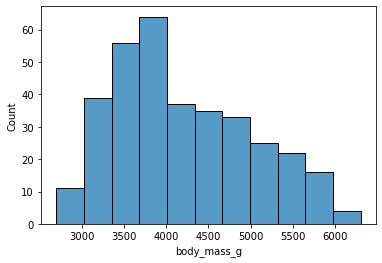

<IPython.core.display.Javascript object>

In [3]:
_ = sns.histplot(penguin_df.body_mass_g)

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_penguin_df = scaler.fit_transform(penguin_df.drop(columns=["species"]))
scaled_penguin_df = pd.DataFrame(scaled_penguin_df, columns=penguin_df.columns[1:])
scaled_penguin_df["species"] = list(penguin_df["species"])
scaled_penguin_df

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,species
0,-0.884499,0.785449,-1.418347,-0.564142,Adelie
1,-0.811126,0.126188,-1.062250,-0.501703,Adelie
2,-0.664380,0.430462,-0.421277,-1.188532,Adelie
3,-1.324737,1.089724,-0.563715,-0.938776,Adelie
4,-0.847812,1.748985,-0.777373,-0.689020,Adelie
...,...,...,...,...,...
337,0.601305,-1.750171,0.931890,0.903175,Gentoo
338,0.527932,-1.445897,1.003109,0.809516,Gentoo
339,1.188289,-0.735923,1.501644,1.933419,Gentoo
340,0.234440,-1.192335,0.789451,1.246590,Gentoo


<IPython.core.display.Javascript object>

In [5]:
scaled_penguin_df.groupby(["species"]).agg(
    mean_culmen_length=pd.NamedAgg(column="culmen_length_mm", aggfunc="mean"),
    std_culmen_length=pd.NamedAgg(column="culmen_length_mm", aggfunc="std"),
    mean_culmen_depth=pd.NamedAgg(column="culmen_depth_mm", aggfunc="mean"),
    std_culmen_depth=pd.NamedAgg(column="culmen_depth_mm", aggfunc="std"),
    mean_flipper_length=pd.NamedAgg(column="flipper_length_mm", aggfunc="mean"),
    std_flipper_length=pd.NamedAgg(column="flipper_length_mm", aggfunc="std"),
    mean_body_mass=pd.NamedAgg(column="body_mass_g", aggfunc="mean"),
    std_body_mass=pd.NamedAgg(column="body_mass_g", aggfunc="std"),
)

,mean_culmen_length,std_culmen_length,mean_culmen_depth,std_culmen_depth,mean_flipper_length,std_flipper_length,mean_body_mass,std_body_mass
species,,,,,,,,
Adelie,-0.941108,0.488555,0.606109,0.616992,-0.780675,0.465735,-0.625754,0.572648
Chinstrap,0.901001,0.612528,0.643753,0.575786,-0.362625,0.507928,-0.585261,0.479950
Gentoo,0.657229,0.565313,-1.099980,0.497600,1.158865,0.461855,1.091761,0.629531


<IPython.core.display.Javascript object>

In [6]:
n_clusters = 3
n_observations, n_features = scaled_penguin_df.shape
with pm.Model() as model:
    cl_sigmas = pm.HalfNormal("cl_sigmas", sigma=1, shape=n_clusters)
    cd_sigmas = pm.HalfNormal("cd_sigmas", sigma=1, shape=n_clusters)
    fl_sigmas = pm.HalfNormal("fl_sigmas", sigma=1, shape=n_clusters)
    bm_sigmas = pm.HalfNormal("bm_sigmas", sigma=1, shape=n_clusters)

    p = pm.Dirichlet("p", a=np.ones(n_clusters))
    category = pm.Categorical("category", p=p, shape=n_observations)

    cl_means = pm.Normal("cl_means", [0] * n_clusters, sd=1, shape=n_clusters)
    cd_means = pm.Normal("cd_means", [0] * n_clusters, sd=1, shape=n_clusters)
    fl_means = pm.Normal("fl_means", [0] * n_clusters, sd=1, shape=n_clusters)
    bm_means = pm.Normal("bm_means", [0] * n_clusters, sd=1, shape=n_clusters)

    y_cl = pm.Normal(
        "y_cl",
        mu=cl_means[category],
        sd=cl_sigmas[category],
        observed=scaled_penguin_df.culmen_length_mm,
    )
    y_cd = pm.Normal(
        "y_cd",
        mu=cd_means[category],
        sd=cd_sigmas[category],
        observed=scaled_penguin_df.culmen_depth_mm,
    )
    y_fl = pm.Normal(
        "y_fl",
        mu=fl_means[category],
        sd=fl_sigmas[category],
        observed=scaled_penguin_df.flipper_length_mm,
    )
    y_bm = pm.Normal(
        "y_bm",
        mu=bm_means[category],
        sd=bm_sigmas[category],
        observed=scaled_penguin_df.body_mass_g,
    )

    trace = pm.sample(10000)

<ipython-input-6-075e2a21c3c7>:42: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(10000)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [bm_means, fl_means, cd_means, cl_means, p, bm_sigmas, fl_sigmas, cd_sigmas, cl_sigmas]
>CategoricalGibbsMetropolis: [category]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 790 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


<IPython.core.display.Javascript object>

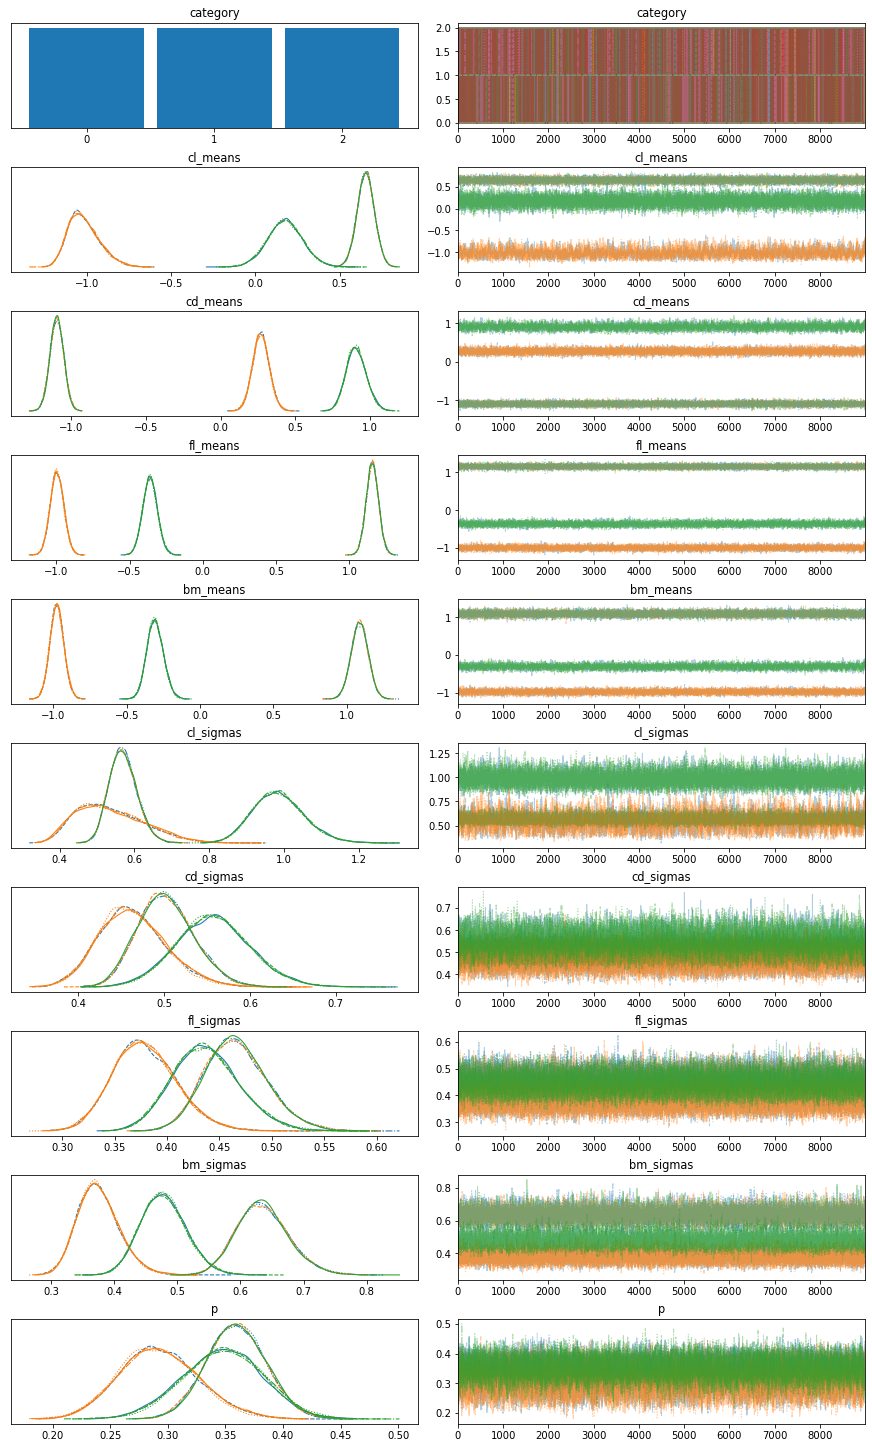

<IPython.core.display.Javascript object>

In [7]:
with model:
    pm.plot_trace(trace[1000:])

In [8]:
groups = [
    f"Group {n+1}"
    for n in list(trace.get_values("category", burn=6000, combine=False)[2][20])
]
penguin_df["group"] = groups
penguin_df

,species,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,group
0,Adelie,39.1,18.7,181.0,3750.0,Group 1
1,Adelie,39.5,17.4,186.0,3800.0,Group 1
2,Adelie,40.3,18.0,195.0,3250.0,Group 3
4,Adelie,36.7,19.3,193.0,3450.0,Group 1
5,Adelie,39.3,20.6,190.0,3650.0,Group 3
...,...,...,...,...,...,...
338,Gentoo,47.2,13.7,214.0,4925.0,Group 2
340,Gentoo,46.8,14.3,215.0,4850.0,Group 2
341,Gentoo,50.4,15.7,222.0,5750.0,Group 2
342,Gentoo,45.2,14.8,212.0,5200.0,Group 2


<IPython.core.display.Javascript object>

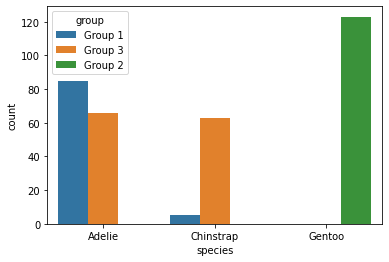

<IPython.core.display.Javascript object>

In [9]:
plot_df = (
    penguin_df.groupby(["species", "group"])
    .count()[["culmen_length_mm"]]
    .reset_index()
    .rename(columns={"culmen_length_mm": "count"})
)

_ = sns.barplot(data=plot_df, x="species", y="count", hue="group")

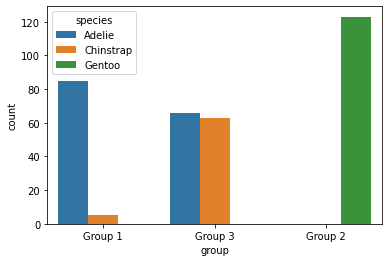

<IPython.core.display.Javascript object>

In [10]:
_ = sns.barplot(data=plot_df, x="group", y="count", hue="species")

So this resolves the sampling issues the previous model had, good. This model also works really well at picking out the Gentoos, but it is still adding a fair number of Adelies with the Chinstraps (which are fairly similar in size and weight so that was to be expected). There also is an issue with using multiple likelihoods that makes it hard to compare the model. A lot of the features to evaluate multiple models don't work on these. So we'll have to come up with a way to use a single likelihood.